## 영상처리와 딥러닝 기말 프로젝트

학번: 20195234 </br>
이름: 임지운 </br>
소속: 빅데이터 전공 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np 
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import tqdm
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/whale-categorization-playground/sample_submission.csv
/kaggle/input/whale-categorization-playground/train.csv
/kaggle/input/whale-categorization-playground/test/0a04314e.jpg
/kaggle/input/whale-categorization-playground/test/096813b1.jpg
/kaggle/input/whale-categorization-playground/test/1f718faf.jpg
/kaggle/input/whale-categorization-playground/test/d488141d.jpg
/kaggle/input/whale-categorization-playground/test/b7f0a998.jpg
/kaggle/input/whale-categorization-playground/test/0b7cab35.jpg
/kaggle/input/whale-categorization-playground/test/67956b0f.jpg
/kaggle/input/whale-categorization-playground/test/c7bf9be2.jpg
/kaggle/input/whale-categorization-playground/test/103083e9.jpg
/kaggle/input/whale-categorization-playground/test/3f80e7ed.jpg
/kaggle/input/whale-categorization-playground/test/89ba59ec.jpg
/kaggle/input/whale-categorization-playground/test/13c4c6a9.jpg
/kaggle/input/whale-categorization-playground/test/f65c2243.jpg
/kaggle/input/whale-categorization-playgroun

In [2]:
!pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [3]:
!pip install pytorch-metric-learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.8 MB/s eta 0:00:00


In [4]:
#!pip install pretrainedmodels > /dev/null

In [5]:
#사전 훈련된 모델을 사용한다.
#이것을 대체하는게 우리가 할 과제이다.
#import pretrainedmodels

In [6]:
#Train data를 Pandas를 통해 읽어온다.
train_df = pd.read_csv("/kaggle/input/whale-categorization-playground/train.csv")
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


현재 trainset은 Image의 이름과 해당 이미지가 어느 고래인지 표기하는 ID로 구성되어 있다.

In [7]:
#input data가 얼마나 있는지 확인하기 위한 출력문. 그리고 몇개의 ID가 있는지 확인한다.
print(f"There are {len(os.listdir('/kaggle/input/whale-categorization-playground/train'))} images in train dataset with {train_df.Id.nunique()} unique classes.")
print(f"There are {len(os.listdir('/kaggle/input/whale-categorization-playground/test'))} images in test dataset.")

There are 9850 images in train dataset with 4251 unique classes.
There are 15610 images in test dataset.


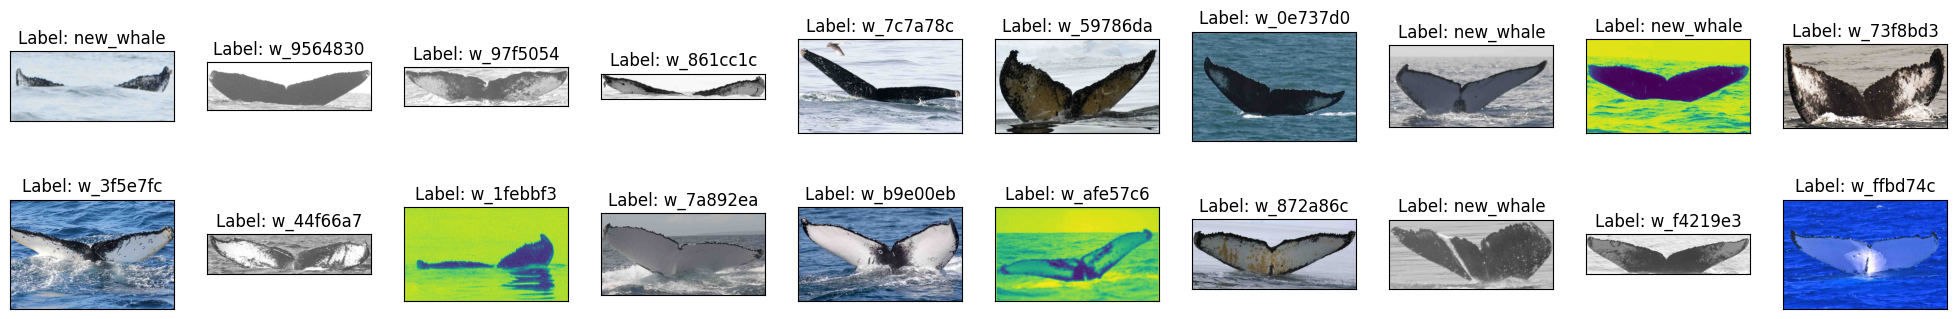

In [8]:
#크기가 25,4인 새로운 figure를 생성한다.
fig = plt.figure(figsize=(25, 4))
#룬련 데이터의 이미지 리스트를 가져온다
train_imgs = os.listdir("/kaggle/input/whale-categorization-playground/train")
#룬련 데이터 중 20장을 랜덤으로 선택하여 가져온다.
#20장을 한 장씩 가져와 2행 10열의 그림에 순차적으로 ID와 함께 표기한다.
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("/kaggle/input/whale-categorization-playground/train/" + img)
    plt.imshow(im)
    lab = train_df.loc[train_df.Image == img, 'Id'].values[0]
    ax.set_title(f'Label: {lab}')

각각의 ID가 몇개의 샘플을 가지고 있는지 표기해준다. </br>
샘플이 1개인 클래스는 2220개 </br>
샘플이 2개인 클래스는 1034개 </br>
샘플이 3개인 클래스는 492개 </br>
.. 로 표현한다.

In [9]:
for i in range(1, 20):
    print(f'There are {train_df.Id.value_counts()[train_df.Id.value_counts().values==i].shape[0]} classes with {i} samples in train data.')

There are 2220 classes with 1 samples in train data.
There are 1034 classes with 2 samples in train data.
There are 492 classes with 3 samples in train data.
There are 192 classes with 4 samples in train data.
There are 102 classes with 5 samples in train data.
There are 61 classes with 6 samples in train data.
There are 40 classes with 7 samples in train data.
There are 23 classes with 8 samples in train data.
There are 21 classes with 9 samples in train data.
There are 9 classes with 10 samples in train data.
There are 7 classes with 11 samples in train data.
There are 7 classes with 12 samples in train data.
There are 9 classes with 13 samples in train data.
There are 5 classes with 14 samples in train data.
There are 4 classes with 15 samples in train data.
There are 5 classes with 16 samples in train data.
There are 4 classes with 17 samples in train data.
There are 2 classes with 18 samples in train data.
There are 2 classes with 19 samples in train data.


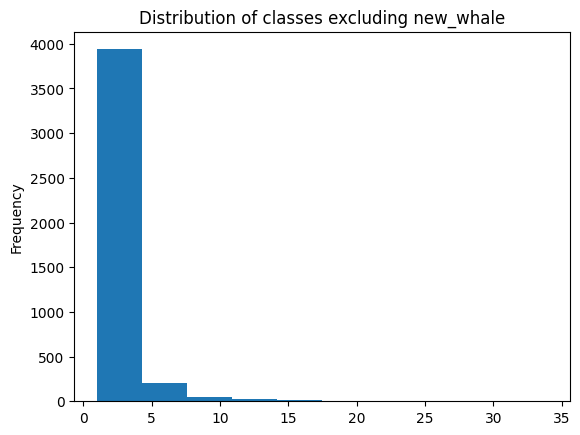

In [10]:
plt.title('Distribution of classes excluding new_whale');
train_df.Id.value_counts()[1:].plot(kind='hist');

In [11]:
#위에서 열었던 for문에서 쓰였던 im의 구조를 확인해보는 것이다. 가로 세로 RGB-channel로 구성되어있다
np.array(im).shape

(700, 1050, 3)

## 정규화를 위한 평균과 표준편차 구하기
참고자료1: https://www.kaggle.com/code/tcapelle/resnet-18-with-fastai </br>
참고자료2: https://www.kaggle.com/code/mgallimore88/train-siamese</br>
fastai는 딥러닝을 위한 오픈 소스 라이브러리 중 하나로 빠르고 유연한 학습을 지원하는데 중점을 둔 프레임워크다. 해당 라이브러리는 PyTorch기반으로 구축되어 있어서 PyTorch와 통합하기도 쉽다. </br>
fastai 라이브러리에서 모듈 resnet18은 자동으로 mean과 std를 계산해주는 모듈이다 </br>

주로 다음과 같이 사용된다. **model_meta[resnet18]** </br>

참고자료2에서 25번째 in을 살펴보면 model_meta[resnet18]으로 mean과 std를 계산하여 정규화하는데 사용하는 것을 확인할 수 있다.

In [62]:
#transform.Normalize(mean, std, inplace = False) -> 기초적인 선언 구조
#10주차에서 데이터들의 mean과 std를 구하는 것을 배웠다.
#하지만 baseline code에서는 이미 mean과 std를 구해 이미지를 가져올 때 Resize와 ToTensor
#정규화를 동시에 처리할 예정이기에 whale-train-data의 mean과 std를 구하는 코드는 따로 작성하지 않을 예정이다.
data_transforms = transforms.Compose([
                                      transforms.Resize((128, 128)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
#데이터 증강을 통해 데이터를 늘린다.
data_transforms_plus = transforms.Compose([
                                      transforms.Resize((128, 128)),
                                      transforms.RandomRotation(degrees=30),  # Random Rotation 추가
                                      transforms.RandomHorizontalFlip(),       # Random Horizontal Flip 추가
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
])
data_transforms_test = transforms.Compose([
                                           transforms.Resize((128, 128)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])

In [63]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    #입력 받은 값을 numpy의 array구조로 변경한다.
    values = np.array(y)
    #LabelEncoder를 통해 문자열 레이블을 정수로 변경한다.
    #다시 말해서 "11111", "12212", "21121" -> 0, 1, 2로 정수로 인코딩 하는 과정
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    #기존 원핫 인코딩
    #이제 정수로 인코딩 된 것을 onehot_encoding을 통해 벡터로 변경한다.
    #예를 들어 0, 1, 2-> [1,0,0], [0,1,0], [0,0,1] 로 변경한다.
    onehot_encoder = OneHotEncoder(sparse_output=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded
    return y, label_encoder
    
    #반환할 떄 label_encoder를 반환하므로 디코딩하는데 사용할 수 있다.
    #Metric Learning으로 분류를 해야하기 때문에 정수형으로 값을 반환해주어야한다.
    #y = torch.tensor(integer_encoded, dtype=torch.long)
    #return y, label_encoder

In [64]:
#고래들의 id를 one-hot 벡터로 변환하고 해당 label_encoder를 가져온다.
y, le = prepare_labels(train_df['Id'])

In [65]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            label = np.zeros((5005,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [66]:
train_dataset = WhaleDataset(datafolder='/kaggle/input/whale-categorization-playground/train/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='/kaggle/input/whale-categorization-playground/test/', datatype='test', transform=data_transforms_test)

In [75]:
from torch.utils.data import ConcatDataset

train_dataset_list = [train_dataset]

for i in range(10):
    new_train_dataset = WhaleDataset(datafolder='/kaggle/input/whale-categorization-playground/train/', datatype='train', df=train_df, transform=data_transforms_plus, y=y)
    train_dataset_list.append(new_train_dataset)

# train_dataset_list 주위의 대괄호를 제거합니다.
train_dataset = ConcatDataset(train_dataset_list)

In [76]:
#suffle을 하는 목적으로 사용한다
train_sampler = SubsetRandomSampler(list(range(len(train_dataset))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('/kaggle/input/whale-categorization-playground/test')))))
batch_size = 512
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
# less size for test loader.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)

In [77]:
#dataloader에 자료가 잘 들어갔는지 확인하기
#for batch_idx, (inputs, labels) in enumerate(train_loader):
#    print(f"Batch {batch_idx + 1} - Input shape: {inputs.shape}, Label shape: {labels.shape}")

Feature batch shape: torch.Size([512, 3, 128, 128])
Labels batch shape: torch.Size([512, 4251])


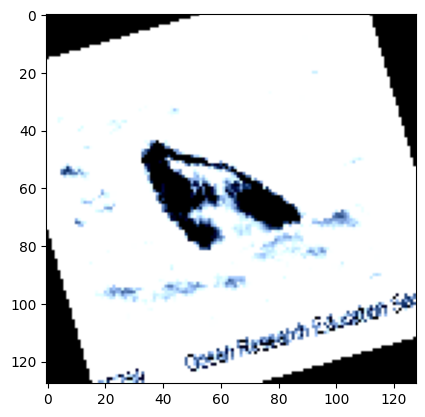

In [78]:
#안에 들어간 이미지가 잘 들어갔는지 확인하기 위해서 출력을 해보았다.
train_features1, train_labels = next(iter(train_loader)) #,train_features2
print(f"Feature batch shape: {train_features1.size()}")
print(f"Labels batch shape: {train_labels.size()}")
#channel이 마지막에 가야하나 여기서는 첫번째로 와있어서 np.transpose로 차원을 변경해주어야한다.
img = np.transpose(train_features1[211], (1, 2, 0))
label = train_labels[211]
plt.imshow(img)
plt.show()

In [79]:
#그레이디언트 소실의 완화와 forward 메서드의 입력과 출력 차원을 일치시켜주기 위해 사용한다.
#특징을 더 추출하기 위해서 사용한다.
class SubBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SubBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, in_channels, kernel_size=1)
        
    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.conv3(out)

        out += identity
        out = F.relu(out)

        return out

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # 브렌치 모델(특징을 추출함)
        self.branch_model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=2, padding=4), #(64,64,64)
            nn.MaxPool2d(2, stride=2), #(64,32,32)
            nn.BatchNorm2d(64), 
            nn.Conv2d(64, 64, kernel_size=3, padding=1), #(64,32,32)
            nn.MaxPool2d(2, stride=2), #(64,16,16)
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=1), #(128,16,16)
            SubBlock(128, 64),
            SubBlock(128, 32),
            nn.MaxPool2d(2, stride=2), #(128,8,8)
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=1), #(256,8,8)
            SubBlock(256, 128),
            SubBlock(256, 64),
            nn.MaxPool2d(2, stride=2),  #(256,4,4)
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=1), #(512,4,4)
            SubBlock(512, 256),
            SubBlock(512, 128),
            nn.MaxPool2d(2, stride=2), #(512,2,2)
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, kernel_size=1), #(1024,2,2)
            SubBlock(1024, 512),
            SubBlock(1024, 256),
            nn.AdaptiveAvgPool2d(1), #(1024,1,1)
        )

        # 헤드 모델(추출한 특징을 target사이즈에 맞춤)
        self.head_model = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4251),
        )

    def forward_one(self, x):
        x = self.branch_model(x)
        x = x.view(x.size()[0], -1)
        x = self.head_model(x)
        return x

    def forward(self, input):
        output = self.forward_one(input)
        return output

In [80]:
#model_conv = pretrainedmodels.resnet18()
#model_conv.avgpool = nn.AvgPool2d((5,10))
#model_conv.last_linear = nn.Linear(model_conv.last_linear.in_features, 4251)
#print(model_conv)

#metric learning에 모듈이 있었다!
#아래는 중간에 pytorch_metric_learning으로 학습을 시켜보았지만 결과가 좋게 나오지 않아 일단 남겨둔 코드다.
#from pytorch_metric_learning import miners, losses
#from pytorch_metric_learning.distances import CosineSimilarity

#Miner 설정 (마이닝 전략) -> 데이터 쌍을 어떻게 만들지 설정하는 함
#miner = miners.TripletMarginMiner()
#miner = miners.AngularMiner()
#miner = miners.MultiSimilarityMiner()
#miner = miners.BatchHardMiner()

#내가 만든 모델
model_conv = SiameseNetwork()

#손실함수, 이진 크로스 엔트로피이다.
criterion = nn.BCEWithLogitsLoss()
#손실함수, Metric Learning의 Triplet Loss이다.
#criterion = losses.TripletMarginLoss(margin=0.2, distance=CosineSimilarity(), smooth_loss=True, triplets_per_anchor='batch')
#손실함수, Metric Learning의 ContrastiveLoss이다.
#criterion = losses.ContrastiveLoss(pos_margin=0.2, neg_margin=1.0)

#최적화 기법 정의
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_conv=model_conv.cuda()

n_epochs = 6
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    exp_lr_scheduler.step()

    for batch_i, (data, target) in enumerate(tqdm.tqdm(train_loader)):
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        
        #Metric Learning
        #data_pairs = miner(output, target)
        #loss = criterion(output, target, data_pairs)
        
        #BCEWithLogitsLoss(), 
        loss = criterion(output, target)
        train_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}')


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Tue Dec  5 12:30:07 2023 Epoch: 1


  6%|▌         | 18/308 [00:59<15:59,  3.31s/it]

In [ ]:
sub = pd.read_csv('/kaggle/input/whale-categorization-playground/sample_submission.csv')

model_conv.eval()
for (data, target, name) in test_loader:
    data = data.cuda()
    output = model_conv(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))
sub.to_csv('submission.csv', index=False)